[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/tensorflow/nn-reg.ipynb)

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

Populating the interactive namespace from numpy and matplotlib


In [2]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0  30025      0 --:--:-- --:--:-- --:--:-- 29992


In [0]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
y = df['group']
df.drop('group', axis='columns', inplace=True)
X = df.as_matrix()

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### We have several means of regularization

 _We use a combination of them:_
- reduce capacity of model
- dropout
- batch normalization
- change activation to relu for faster training
- reduce amount of training cycles

## Dropout explained in a funny way

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/dropout-smerty.jpg'>

https://twitter.com/Smerity/status/980175898119778304

### An experimental approach:
- keep adding regularization to make validation and train scores come closer to each other
- this will come at the cost of train scores going down
- if both values start going down you have gone too far
- each experiment takes some time
- for larger datasets and more complex models some people start by overfitting on a subsample of the data (because it trains much faster)
  - then you can be sure you have an architecture that at least has the capacity to solve the problem
  - then keep adding regularizations
  - eventually try using the complete data
- if you want to use batch normalization place it between raw output of neuron and activation function    

In [6]:
from tensorflow.keras.layers import Dense, Dropout, \
                                    BatchNormalization, Activation

dropout = 0.6
model = keras.Sequential()

# reduce capacity by decreasing number of neurons
model.add(Dense(500, name='hidden1', input_dim=3))
# model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(dropout))

model.add(Dense(500, name='hidden2'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(dropout))

model.add(Dense(3, name='softmax', activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               2000      
_________________________________________________________________
activation_2 (Activation)    (None, 500)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_3 (Activation)    (None, 500)               0         
_________________________________________________________________
softmax (Dense)              (None, 3)                 1503      
Total params: 254,003
Trainable params: 254,003
Non-trainable params: 0
_________________________________________________________________


In [7]:
# reducing batch size might increase overfitting, 
# but might be necessary to reduce memory requirements 
BATCH_SIZE=1000

# reduce this based on what you see in the training history
EPOCHS = 10000

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

%time history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)

CPU times: user 1min 31s, sys: 15 s, total: 1min 45s
Wall time: 1min 18s


In [8]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_accuracy

1200/1200 [==============================] - 0s 11us/step


0.8558333118756613

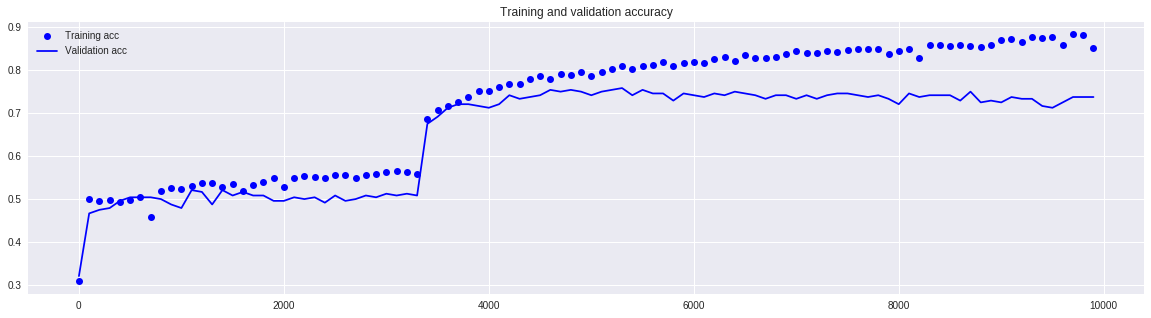

In [9]:
def plot_history(history, samples=100, init_phase_samples=None):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]

    fig, ax = plt.subplots(figsize=(20,5))

    ax.plot(acc, 'bo', label='Training acc')
    ax.plot(val_acc, 'b', label='Validation acc')
    ax.set_title('Training and validation accuracy')
    ax.legend()

plot_history(history)

In [10]:
model.predict(np.array([[100, 47, 10]]))

array([[0.01183631, 0.9730243 , 0.01513934]], dtype=float32)

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_accuracy

300/300 [==============================] - 0s 16us/step


0.6933333277702332